<a href="https://colab.research.google.com/github/abyki/ml/blob/main/hw2/hw2_akaev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import numpy as np
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from random import sample
import os
from datetime import datetime, timedelta
from calendar import monthrange
from tqdm.notebook import tqdm

In [79]:
class LogisticRegression:
    """
    Logistic regression for scatch on PyTorch.
    Batching not implemented.
    
    """
    
    def __init__(self, device='cpu'):
        self.device = device
     
    
    def forward(self, x, w, b):
        z = torch.dot(x, w).reshape(1)
        z += b
        p = 1.0 / (1.0 + torch.exp(-z))
        return p
        
    def fit(self, X, y, penalty=False, epochs=50, learning_rate=3e-4, verbose=1):
        
        self.X = X.to(self.device) 
        self.y = y.to(self.device)
        
        if penalty:
            assert (penalty == 'l2') or (penalty == 'l1')
        self.penalty = penalty
        
        assert self.X.size(0) == self.y.size(0)
        
        
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        self.w = torch.rand(self.X.size(1), dtype=torch.float32, requires_grad=True).to(self.device)
        
        self.w.grad = torch.zeros(self.X.size(1))
        self.w.retain_grad()

        self.b = torch.zeros(1, dtype=torch.float32, requires_grad=True).to(self.device)
        self.b.grad = torch.zeros(1)
        self.b.retain_grad()
        
        
        indices = np.arange(self.X.size(0))
        for epoch in tqdm(range(self.epochs)):
            tot_loss = torch.zeros(1, dtype=torch.float32, requires_grad=True).to(device)
            tot_loss.grad = torch.zeros(1)
            tot_loss.retain_grad()
            
            np.random.shuffle(indices)
            for i in indices:
                x = self.X[i]
                target = self.y[i]
                out = self.forward(x=x, w=self.w, b=self.b)
                # почему такой лосс?
                loss = (out - target).pow(2).sum()
                tot_loss = loss + tot_loss
            
            tot_loss = tot_loss 
            if self.penalty == 'l1':
                tot_loss = tot_loss + torch.norm(self.w, p=1)
            elif self.penalty == 'l2':
                tot_loss = tot_loss + torch.norm(self.w, p=2)
                
            tot_loss.backward(retain_graph=True)  # compute gradients

            self.w.data += -1 * self.learning_rate * self.w.grad.data
            self.b.data += -1 * self.learning_rate * self.b.grad.data

            self.w.grad = torch.zeros(self.X.size(1))
            self.b.grad = torch.zeros(1)

            if epoch % verbose == 0:
                print(f"Epoch {epoch} / {self.epochs}", end="")
                print("   Loss = %6.4f" % (tot_loss / self.X.size(0)))
        
        print(f"Total loss = %6.4f" % (tot_loss / self.X.size(0)))

    def predict_score(self, x):
        return torch.matmul(x, self.w) + self.b
    
    def predict_proba(self, x):
        p = 1.0 / (1.0 + torch.exp(-self.predict_score(x)))
        return p

In [63]:
x = torch.eye(4, 5)
w = 2 * torch.ones(5)

In [64]:
torch.matmul(x, w) + 1

tensor([3., 3., 3., 3.])

In [65]:
target_median = np.median(df.PRES)
df['target'] = np.where(df.PRES >= target_median, 1, 0)

In [66]:
df['month_sin'] = np.sin(2 * np.pi * df.month / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df.month / 12.0)

df['hour_sin'] = np.sin(2 * np.pi * df.hour / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df.hour / 24.0)

df['day_of_month_sin'] = df.apply(lambda r: np.sin(2 * np.pi * r.day / monthrange(r.year, r.month)[1]),
                                  axis=1)
df['day_of_month_cos'] = df.apply(lambda r: np.cos(2 * np.pi * r.day / monthrange(r.year, r.month)[1]),
                                  axis=1)

In [67]:
df_train = df[df.year < 2015]
df_val = df[df.year >= 2015]

In [68]:
df_train.shape, df_val.shape

((14587, 24), (6849, 24))

In [69]:
from category_encoders import (
    JamesSteinEncoder, 
    CatBoostEncoder, 
    TargetEncoder
)

ce_target = TargetEncoder(cols = ['cbwd'])

ce_target.fit(df_train.cbwd, df_train.target)

df_train['cbwd_te'] = ce_target.transform(df_train.cbwd).cbwd.values
df_val['cbwd_te'] = ce_target.transform(df_val.cbwd).cbwd.values

In [70]:
df_train.shape, df_val.shape

((14587, 25), (6849, 25))

In [71]:
used_cols = ['year', 'month_sin', 'month_cos', 'day_of_month_sin',
             'day_of_month_cos', 'hour_sin', 'hour_cos', 
             'cbwd_te', 'season', 'PM_Jingan',
             'PM_US Post', 'PM_Xuhui', 'DEWP', 'HUMI', 'TEMP', 'Iws',
             'precipitation', 'Iprec']
target = 'target'

In [72]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df_train[used_cols])
x_val = sc.transform(df_val[used_cols])

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [77]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(df_train.target.values, dtype=torch.long).to(device)

In [80]:
cls = LogisticRegression(device=device)

cls.fit(x_train, y_train, penalty='l2', epochs=100, verbose=5, learning_rate=3e-3)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 / 100   Loss = 0.2585
Epoch 5 / 100   Loss = 0.0647
Epoch 10 / 100   Loss = 0.0623
Epoch 15 / 100   Loss = 0.0611
Epoch 20 / 100   Loss = 0.0602
Epoch 25 / 100   Loss = 0.0596
Epoch 30 / 100   Loss = 0.0593
Epoch 35 / 100   Loss = 0.0590
Epoch 40 / 100   Loss = 0.0589
Epoch 45 / 100   Loss = 0.0588
Epoch 50 / 100   Loss = 0.0588
Epoch 55 / 100   Loss = 0.0587
Epoch 60 / 100   Loss = 0.0587
Epoch 65 / 100   Loss = 0.0587
Epoch 70 / 100   Loss = 0.0587
Epoch 75 / 100   Loss = 0.0589
Epoch 80 / 100   Loss = 0.0635
Epoch 85 / 100   Loss = 0.0651
Epoch 90 / 100   Loss = 0.0611
Epoch 95 / 100   Loss = 0.0602
Total loss = 0.0601


In [82]:
x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val = torch.tensor(df_val.target.values, dtype=torch.long).to(device)

In [83]:
y_pred = cls.predict_proba(x_val).detach().cpu().numpy()

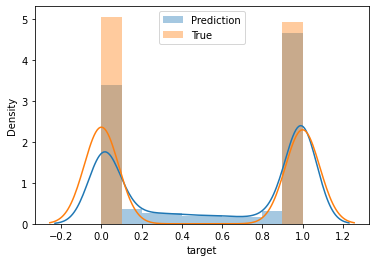

In [84]:
import seaborn as sns

sns.distplot(y_pred, label='Prediction')
sns.distplot(df_val.target, label='True')
plt.legend()
plt.show()

In [85]:
df_val.target.value_counts()

0    3471
1    3378
Name: target, dtype: int64

In [86]:
y_pred.min(), y_pred.max()

(3.3469306e-12, 1.0)

In [87]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score
)
def report(y_true, y_pred_proba):
    y_pred_labels = np.where(y_pred_proba >= 0.5, 1, 0)
    print('Accuracy:  \t{}'.format(accuracy_score(y_true, y_pred_labels)))
    print('F1-score:  \t{}'.format(f1_score(y_true, y_pred_labels)))
    print('Recall:    \t{}'.format(recall_score(y_true, y_pred_labels)))
    print('ROCAUC:    \t{}'.format(roc_auc_score(y_true, y_pred_proba)))

In [88]:
report(df_val.target, y_pred)

Accuracy:  	0.9163381515549716
F1-score:  	0.9200279134682484
Recall:    	0.9757252812314979
ROCAUC:    	0.973791982593148


In [89]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df_train[used_cols])
x_val = sc.transform(df_val[used_cols])

In [90]:
from sklearn.linear_model import LogisticRegression as lr

lr_sklearn = lr(penalty='l2', C=1.0)
lr_sklearn.fit(x_train, df_train.target.values)

LogisticRegression()

In [91]:
y_pred_sklearn = lr_sklearn.predict_proba(x_val)

In [92]:
report(df_val.target, y_pred_sklearn[:, 1])

Accuracy:  	0.926704628412907
F1-score:  	0.9270348837209302
Recall:    	0.9440497335701599
ROCAUC:    	0.9780052738421829



*   Результаты моделей при одинаковых гиперпараметрах оказались очень похожими
*   AUC модели из sklearn чуть лучше, чем у нашей модели
*   У нашей модели меньше ошибка 2-го рода, но ошибка 1-го рода больше